In [1]:
from fastkml import kml

#lets start with some imports

#Py-ART, simply the best sowftware around.. Give those guys a grant
import pyart

#Boto3 is the AWS SDK
import boto3

#botocore contains core configuration utilities for boto2 and boto3
from botocore.handlers import disable_signing

#Tempory files in Python.. A very useful module
import tempfile

#datetime modules.. very handy!
from datetime import datetime

#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop
import cartopy

import cartopy.io.img_tiles as cimgt

import numpy as np

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/anaconda3/envs/groundfail/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def find_my_key(radar_name, desired_datetime):
    """
    Find the key in Amazon s3 corresponding to a particular radar site and 
    datetime
    
    Parameters
    ----------
    radar_name : str
        Four letter radar name
    desired_datetime : datetime
        The date time desired
    Returns
    -------
    my_key : string
        string matching the key for the radar file on AWS s3
    """
    
    bucket = "noaa-nexrad-level2"
    # Create a s3 "client"
    s3 = boto3.resource('s3')
    # Set it to unsigned 
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+radar_name)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix=target_string)]
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix=target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], '%Y%m%d_%H%M%S'))
        except ValueError:
            pass #usually a tar file left in the bucket
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    my_key = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    return my_key

In [3]:
def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
                  fs=None, oset=2000):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(cartopy.crs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = cartopy.crs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = 'yellow'
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == 'yellow':
            barcol = 'blue'
        else:
            barcol = 'yellow'
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby + oset, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col, fontsize=fs)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby + oset , str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col, fontsize=fs)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
            verticalalignment='bottom', color=col, fontsize=fs)


In [4]:
fname = '../data/EelRiver_Polygon.kml'
data = open(fname, 'rb')
content = data.read()
data.close()
k = kml.KML()

k.from_string(content)

In [5]:
features = list(k.features())
len(features)
print(features[0].features())
f2 = list(features[0].features())
print(len(f2))


# Check specifics of the first Placemark in the Document
print(f2[0])
print(f2[0].description)
print(f2[0].name)


<generator object _Container.features at 0x10a609e60>
1
None
EelRiver_InSAR_CEOS


In [6]:
p = f2[0]

In [7]:
lon = np.mean(p.geometry.boundary.xy[0])
lat = np.mean(p.geometry.boundary.xy[1])


In [8]:
print(lat, lon)

39.88211204972399 -123.40756233181723


Looks like KDAX or KBBX


In [9]:
# So we start with bucket neame
bucket = "noaa-nexrad-level2"
# Create a s3 "client"
s3 = boto3.resource('s3')
# Set it to unsigned 
s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

#So now we connect to the bucket with the radar data
aws_radar = s3.Bucket(bucket)




In [10]:

my_datetime = datetime(2018,4,6,20,0)



2018/04/06/KDAX/KDAX20180406_195916_V06
Friday April 06 2018 at 12:59 PM PDT


/Users/scollis/anaconda3/envs/groundfail/lib/python3.6/site-packages/cartopy/img_transform.py:78: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


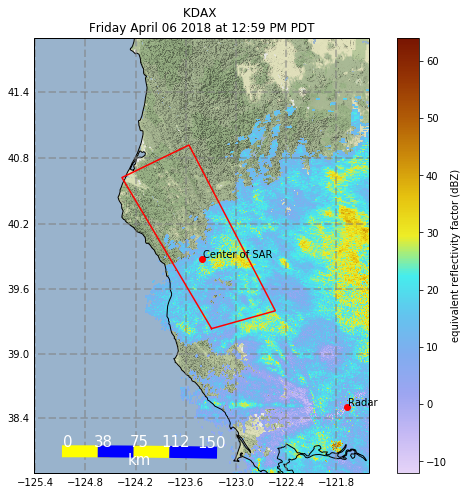

In [11]:
my_key = find_my_key('KDAX', my_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
aws_radar.download_file(my_key, localfile.name)

radar = pyart.io.read(localfile.name)
#Sweep we want to plot
sweep = 0

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d %Y at %I:%M %p %Z')
print(fancy_date_string)

#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = lat
lon_0 = lon

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=lat-5.0, max_latitude=lat+5.0)

title = 'KDAX \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=lon-2.0, max_lon=lon+2.0, min_lat=lat-2.0, max_lat=lat+2.0,
    vmin=-12, vmax=64, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='Center of SAR')
display.plot_point(display.loc[1], display.loc[0], label_text='Radar')

display.plot_line_geo(np.array(p.geometry.boundary.xy[0]),
                      np.array(p.geometry.boundary.xy[1]))

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    plt.gca().add_image(request, 10, zorder=0)

scale_bar_left(plt.gca(), linewidth=12, fs=15, col='white', length=150)


2018/04/06/KBBX/KBBX20180406_200010_V06
Friday April 06 2018 at 01:00 PM PDT


/Users/scollis/anaconda3/envs/groundfail/lib/python3.6/site-packages/cartopy/img_transform.py:78: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


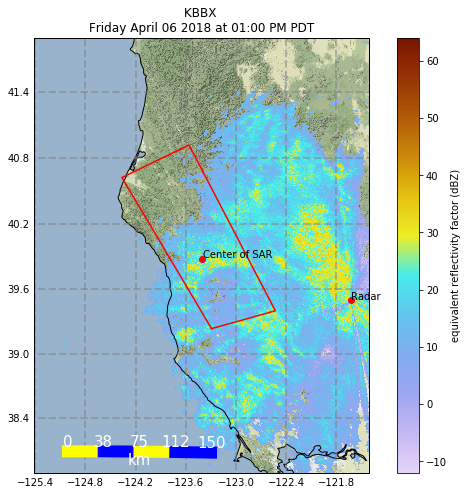

In [12]:

my_key = find_my_key('KBBX', my_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
aws_radar.download_file(my_key, localfile.name)

radar = pyart.io.read(localfile.name)
#Sweep we want to plot
sweep = 0

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d %Y at %I:%M %p %Z')
print(fancy_date_string)
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = lat
lon_0 = lon

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=lat-5.0, max_latitude=lat+5.0)

title = 'KBBX \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=lon-2.0, max_lon=lon+2.0, min_lat=lat-2.0, max_lat=lat+2.0,
    vmin=-12, vmax=64, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='Center of SAR')
display.plot_point(display.loc[1], display.loc[0], label_text='Radar')

display.plot_line_geo(np.array(p.geometry.boundary.xy[0]),
                      np.array(p.geometry.boundary.xy[1]))

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    plt.gca().add_image(request, 10, zorder=0)

scale_bar_left(plt.gca(), linewidth=12, fs=15, col='white', length=150)


2018/04/06/KBHX/KBHX20180406_200010_V06
Friday April 06 2018 at 01:00 PM PDT


/Users/scollis/anaconda3/envs/groundfail/lib/python3.6/site-packages/cartopy/img_transform.py:78: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


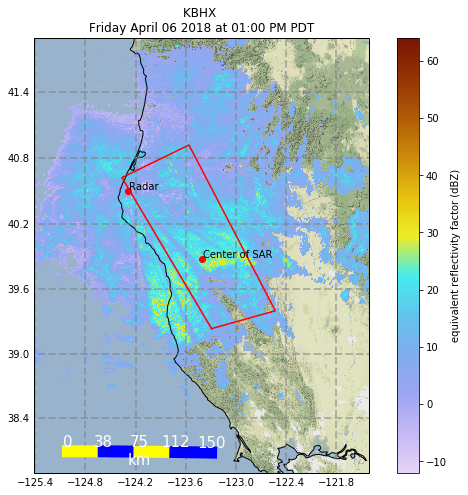

In [13]:


my_key = find_my_key('KBHX', my_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
aws_radar.download_file(my_key, localfile.name)

radar = pyart.io.read(localfile.name)
#Sweep we want to plot
sweep = 0

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d %Y at %I:%M %p %Z')
print(fancy_date_string)
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = lat
lon_0 = lon

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=lat-5.0, max_latitude=lat+5.0)

title = 'KBHX \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=lon-2.0, max_lon=lon+2.0, min_lat=lat-2.0, max_lat=lat+2.0,
    vmin=-12, vmax=64, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='Center of SAR')
display.plot_point(display.loc[1], display.loc[0], label_text='Radar')

display.plot_line_geo(np.array(p.geometry.boundary.xy[0]),
                      np.array(p.geometry.boundary.xy[1]))

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    plt.gca().add_image(request, 10, zorder=0)

scale_bar_left(plt.gca(), linewidth=12, fs=15, col='white', length=150)


2018/04/06/KBHX/KBHX20180406_200010_V06
Friday April 06 2018 at 01:00 PM PDT


/Users/scollis/anaconda3/envs/groundfail/lib/python3.6/site-packages/cartopy/img_transform.py:78: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


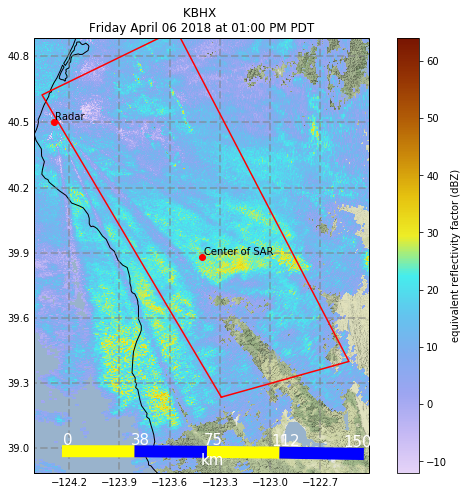

In [14]:


my_key = find_my_key('KBHX', my_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
aws_radar.download_file(my_key, localfile.name)

radar = pyart.io.read(localfile.name)
#Sweep we want to plot
sweep = 0

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d %Y at %I:%M %p %Z')
print(fancy_date_string)
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = lat
lon_0 = lon

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=lat-5.0, max_latitude=lat+5.0)

title = 'KBHX \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=lon-1.0, max_lon=lon+1.0, min_lat=lat-1.0, max_lat=lat+1.0,
    vmin=-12, vmax=64, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='Center of SAR')
display.plot_point(display.loc[1], display.loc[0], label_text='Radar')

display.plot_line_geo(np.array(p.geometry.boundary.xy[0]),
                      np.array(p.geometry.boundary.xy[1]))

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    plt.gca().add_image(request, 10, zorder=0)

scale_bar_left(plt.gca(), linewidth=12, fs=15, col='white', length=150)


2018/04/06/KBHX/KBHX20180406_200010_V06
Friday April 06 2018 at 01:01 PM PDT


/Users/scollis/anaconda3/envs/groundfail/lib/python3.6/site-packages/cartopy/img_transform.py:78: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


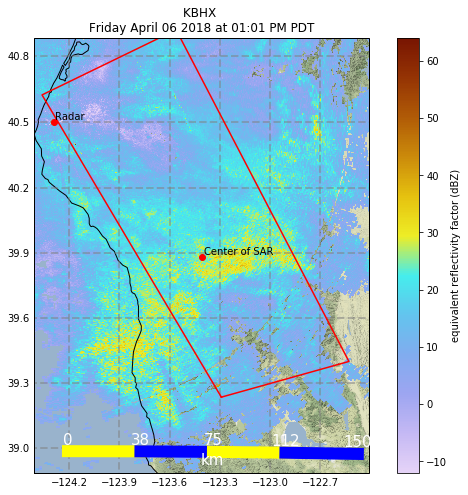

In [15]:


my_key = find_my_key('KBHX', my_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
aws_radar.download_file(my_key, localfile.name)

radar = pyart.io.read(localfile.name)
#Sweep we want to plot
sweep = 3

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d %Y at %I:%M %p %Z')
print(fancy_date_string)
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = lat
lon_0 = lon

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=lat-5.0, max_latitude=lat+5.0)

title = 'KBHX \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=lon-1.0, max_lon=lon+1.0, min_lat=lat-1.0, max_lat=lat+1.0,
    vmin=-12, vmax=64, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='Center of SAR')
display.plot_point(display.loc[1], display.loc[0], label_text='Radar')

display.plot_line_geo(np.array(p.geometry.boundary.xy[0]),
                      np.array(p.geometry.boundary.xy[1]))

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    plt.gca().add_image(request, 10, zorder=0)

scale_bar_left(plt.gca(), linewidth=12, fs=15, col='white', length=150)


2018/04/06/KBHX/KBHX20180406_200010_V06
Friday April 06 2018 at 01:01 PM PDT


/Users/scollis/anaconda3/envs/groundfail/lib/python3.6/site-packages/cartopy/img_transform.py:78: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


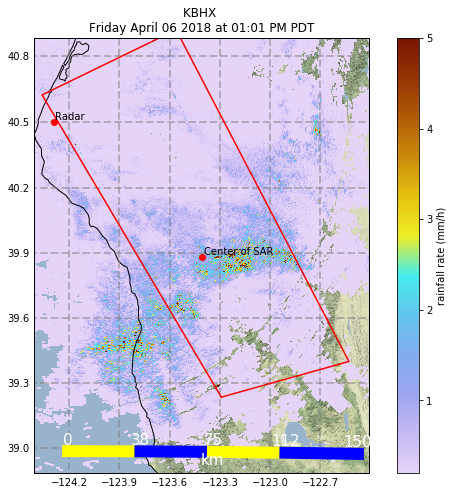

In [16]:



my_key = find_my_key('KBHX', my_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
aws_radar.download_file(my_key, localfile.name)

radar = pyart.io.read(localfile.name)

rain_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
radar.fields['rain_z']['units'] = 'mm/h'
radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
radar.fields['rain_z']['valid_min'] = 0
radar.fields['rain_z']['valid_max'] = 500




#Sweep we want to plot
sweep = 3



#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d %Y at %I:%M %p %Z')
print(fancy_date_string)
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = lat
lon_0 = lon

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=lat-5.0, max_latitude=lat+5.0)

title = 'KBHX \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_z', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=lon-1.0, max_lon=lon+1.0, min_lat=lat-1.0, max_lat=lat+1.0,
    vmin=0.2, vmax=5, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='Center of SAR')
display.plot_point(display.loc[1], display.loc[0], label_text='Radar')

display.plot_line_geo(np.array(p.geometry.boundary.xy[0]),
                      np.array(p.geometry.boundary.xy[1]))

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    plt.gca().add_image(request, 10, zorder=0)

scale_bar_left(plt.gca(), linewidth=12, fs=15, col='white', length=150)
